# **<center><font style="color:rgb(100,109,254)">Module 3: Advance Gesture Controlled Shape/Object Manipulation </font></center>**

<center>
    <img src='https://drive.google.com/uc?export=download&id=1OGxEgnz1eeMKP-y9dvYtBfV1Zc5VR1to'>
    <a href='https://www.microsoft.com/en-us/hololens/developers'>HoloLens photo courtesy of Microsoft</a>
</center>


## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:


- *Lesson 1: Create a Basic Hand Paint Application*

- *Lesson 2: Add Adjustable Paint Color Functionality*

- *Lesson 3: Draw Shapes/Objects utilizing Hand Gestures* 

- ***Lesson 4:* Manipulate Shapes/Objects utilizing Hand Gestures** *(This Tutorial)*

**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section, which is in the last cell of this notebook.
-Taha Anwar

Alright, without further ado, let's dive in.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First, we will import the required libraries.

In [1]:
import cv2
import math
import numpy as np
import mediapipe as mp
from collections import deque
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from previous_lesson import (detectHandsLandmarks, calculateDistance, recognizeGestures,
                             selectShape, drawShapes)

## **<font style="color:rgb(134,19,348)">Initialize the Hands Landmarks Detection Model</font>**

After that, as we have been doing in the previous lessons, we will need to initialize the **`mp.solutions.hands`** class and then set up the **`mp.solutions.hands.Hands()`** function with appropriate arguments and also initialize **`mp.solutions.drawing_utils`** class that is needed to visualize the detected landmarks. 

In [2]:
# Initialize the mediapipe hands class.
mp_hands = mp.solutions.hands

# Set up the Hands functions for videos.
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, 
                       min_detection_confidence=0.8, min_tracking_confidence=0.9)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

## **<font style="color:rgb(134,19,348)">Create a Function to Resize Shapes/Objects</font>**

Now we will create a function **`resizeDrawing()`** that will increase and decrease the size of shapes/objects drawn on a canvas image. We will utilize the [**`cv2.findContours()`**](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) function to get the contours (boundary) points of the shapes/objects and the [**`cv2.boundingRect()`**](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7) to get the current size of a shape/object. Furthermore, we will also need the center points of the shapes, for that, we will utilize [image moments](https://en.wikipedia.org/wiki/Image_moment), returned by the function [**`cv2.moments()`**](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139) to calculate centroids and scale up and down each shape/object in the canvas (region of interest). 

We will also use the [**`cv2.approxPolyDP()`**](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c) function to reduce the number of points around the boundaries of the objects/shapes that will increase the efficiency of the whole process. And then, in the end, after the scaling, we will draw the resized shapes/objects using the function [**`cv2.drawContours()`**](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc).

<center><img src='https://drive.google.com/uc?export=download&id=1-Wh4gxADQZU4I4pGsm2wgYcCohQnltjk'></center>

In [3]:
def resizeDrawing(canvas, roi_points, required_shape_size, display=True):
    '''
    This function will increase or decrease the size of the drawings in a canvas roi.
    Args:
        canvas:              A black (three channel) image with shapes/objects drawn on in different colors.
        roi_points:          The region (containing the shapes/objects to resize) of interest coordinates.
        required_shape_size: The size to which the shapes in the canvas roi need to be resized.
        display:             A boolean value that is if set to true the function displays the input canvas image, 
                             and the output canvas image with shapes resized and returns nothing.
    Returns:
        output_canvas: A copy of input canvas image with the shapes resized.
    '''
    # Create a copy of the input canvas image.
    output_canvas = canvas.copy()
    
    # Get the region (containing the shapes/objects) of interest coordinates.
    x1, y1, x2, y2 = roi_points
    
    # Get the region of interest of the canvas image.
    canvas_roi = output_canvas[y1:y2, x1:x2]
    
    # Create a binary mask of the retrieved canvas roi, 
    # with values 255 at the objects/shapes regions and 0 at the remaining regions.
    binary_mask = np.zeros(shape=(canvas_roi.shape[0], canvas_roi.shape[1]), dtype=np.uint8)
    binary_mask[np.mean(canvas_roi, axis=2)!=0] = 255
    
    # Perform Contour Detection on the binary mask of the canvas roi.
    contours, _ = cv2.findContours(image=binary_mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    # Initialize a list to store the scaled shape/object contours.
    scaled_contours = []
    
    # Initialize a list to store the shapes colors.
    shapes_colors = []
    
    # Check if any shapes/objects contours were found in the canvas roi.
    if len(contours) > 0:
        
        # Iterate over the found shapes/objects contours.
        for cnt in contours:
            
            # Get the bounding rectangle coordinates for the shape/object, we are iterating upon.
            # We only need the height of the shape/object.
            _, _, _, height = cv2.boundingRect(cnt)
            
            # Get the image moments for the contour, we are iterating upon.
            M = cv2.moments(cnt)
            
            # Check if the area of the contour is not zero, to avoid division by zero.
            if M['m00'] != 0:

                # Calculate the centroid of the contour.
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                
                # Get the paint color of the shape/object and append it into the list.
                shapes_colors.append(canvas_roi[cy,cx].copy())
            
                # Iterate until the required shape/object size is not equal to the shape/object actual size.
                # We are allowing the difference of 10 units between the required size and actual size.
                # Means actual size can be 10 units smaller or greater than the required size.
                while not (required_shape_size>=height-10 and required_shape_size<=height+10):

                    # Perform approximation of the contour.
                    # This reduces the number of points in a curve by approximating it to a series of short line segments.
                    # So it will reduce the computations and we are setting epsilon (specifies the approximation accuracy)
                    # equal to 1% of the perimeter of the contours (curve length) as this seem to work perfectly fine for our use-case.
                    approx_cnt = cv2.approxPolyDP(curve = cnt, epsilon = 0.01*cv2.arcLength(cnt, True), closed = True)
                    
                    # Convert the contour values into the float type.
                    approx_cnt = np.array(approx_cnt, dtype=np.float64)
                
                    # Translate the contours to the origin of the image, by subtracting its centroid.
                    # Note that to increase the size we have to decrease the values less than the centroid, and
                    # increse the values greater than the centroid, and vice versa to decrease the size of a shape.
                    # This normalization step will make the values less than the centroid negative and values
                    # greater than the centroid positive, allowing us to increase/decrease size by just multiplying with a constant value.
                    approx_cnt = approx_cnt - (cx, cy)
                    
                    # Check if the required height is greater than the actual height.
                    if required_shape_size > height:
                        
                        # Scale up (increase) the size of the contour.
                        scaled_cnt = approx_cnt * 1.1
                    
                    # Check if the required height is smaller than the actual height.
                    elif required_shape_size < height:
                        
                        # Scale down (decrease) the size of the contour.
                        scaled_cnt = approx_cnt * 0.9

                    # Translate the contour back to its original position by adding its centroid.
                    scaled_cnt = scaled_cnt + (cx, cy)
                    
                    # Convert the contour values into int32 type.
                    cnt = np.array(scaled_cnt, np.int32)
                    
                    # Get the new height of the shape/object.
                    _, _, _, height = cv2.boundingRect(cnt)
                
                # Append the scaled shape/object contour into the list.
                scaled_contours.append(cnt)
        
    # Check if the scaled contours list has length > 0.
    if len(scaled_contours) > 0:
        
        # Clear the canvas roi.
        canvas_roi[:] = 0
        
        # Iterate over the times equal to the length of the scaled contours list.
        for i in range(len(scaled_contours)):

            # Get the color of the shape/object, we are iterating upon.
            paint_color = shapes_colors[i]
            
            # Draw the scaled shape/object on the canvas roi.
            canvas_roi = cv2.drawContours(image=canvas_roi, contours=[scaled_contours[i]], contourIdx=-1, 
                                          color=(int(paint_color[0]),int(paint_color[1]),
                                                 int(paint_color[2])), thickness=-1)
        
        # Update the output canvas with the modified roi.
        output_canvas[y1:y2, x1:x2] = canvas_roi
        
    # Check if the input canvas image and the output canvas image are specified to be displayed.
    if display:
        
        # Display the input canvas image and the output canvas image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(canvas[:,:,::-1]);plt.title("Input Canvas");plt.axis('off');
        plt.subplot(122);plt.imshow(output_canvas[:,:,::-1]);plt.title("Output Canvas");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output canvas image.
        return output_canvas

Now lets read a few sample canvas images using the function [**`cv2.imread()`**](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) and then utilize the function **`resizeDrawing()`** created above, to increase and decrease the size of the shapes/objects in it and display the results.

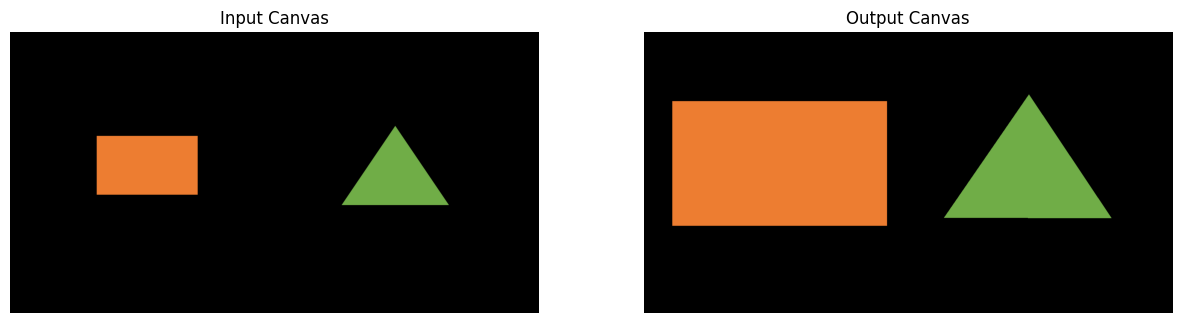

In [4]:
# Read a canvas image and resize drawings on it.
canvas = cv2.imread('media/canvas1.png')
resizeDrawing(canvas, roi_points=(0,0,canvas.shape[1],canvas.shape[0]), required_shape_size=400)

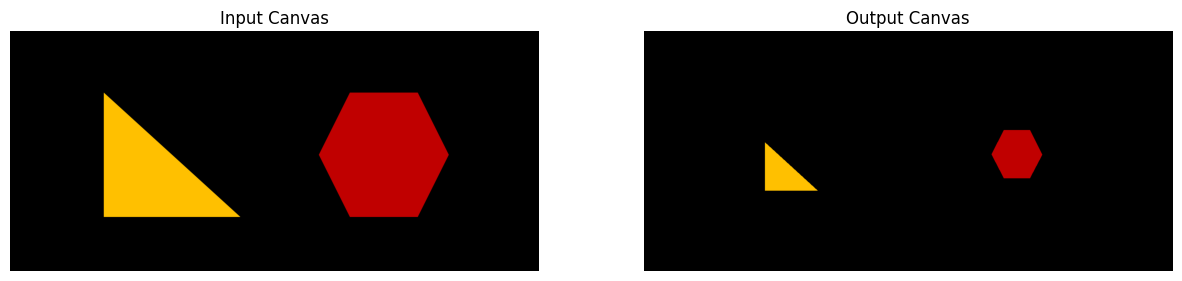

In [5]:
# Read another canvas image and resize drawings on it.
canvas = cv2.imread('media/canvas2.png')
resizeDrawing(canvas, roi_points=(0,0,canvas.shape[1],canvas.shape[0]), required_shape_size=150)

Cool! the resizing operation is working perfectly fine. Now let's move on to the next one.

## **<font style="color:rgb(134,19,348)">Create a Function to Rotate Shapes/Objects</font>**

We will create a function **`rotateDrawing()`** that will utilize a helper function **`rotate()`** to rotate each contour point of the shapes (in counterclockwise direction) in the canvas w.r.t the center of the shapes/objects being the orgin. For this operation too, we will need the [**`cv2.findContours()`**](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0), [**`cv2.moments()`**](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139), [**`cv2.approxPolyDP()`**](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c), and [**`cv2.drawContours()`**](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc) functions to perform the operation.

<center><img src='https://drive.google.com/uc?export=download&id=1ZCCvhAL9Xv4tQtfErfIUq1ygAa4cB7m4'></center>

In [6]:
def rotateDrawing(canvas, roi_points, angle, shapes=None, prev_roi=[], display=True):
    '''
    This function will rotate the drawings in a canvas roi.
    Args:
        canvas:     A black (three channel) image with shapes/objects drawn on in different colors.
        roi_points: The region (containing the shapes/objects to resize) of interest coordinates.
        angle:      The angle (in degrees) with which the shapes are to be rotated.
        shapes:     The contours of the shapes that are to be rotated.
        prev_roi:   The region of interest coordinates of the canvas selected before starting the rotation.
        display:    A boolean value that is if set to true the function displays the input canvas image, 
                    and the output canvas image with shapes rotated and returns nothing.
    Returns:
        output_canvas: A copy of input canvas image with the shapes rotated.
        shapes:        The contours of the shapes that are rotated.
        prev_roi:      The region of interest coordinates of the canvas that was selected before starting the rotation.
    '''
    
    # Define a helper nested function to rotate each contour point of the shapes/objects.
    # We are defining it inside this function scope because we need this rotate() function only here.
    def rotate(point, origin, angle):
        '''
        This function rotates a point (x, y) by an angle (counterclockwise) around the origin.
        Args:
            point:  The x and y coordinates values of the point to be rotated.
            origin: The x and y coordinates values of the origin around which the rotation will be performed.
            angle:  The angle (in degrees) with which the point is to be rotated.
        Returns:
            rotated_x: The x-coordinate value of the rotated point.
            rotated_y: The y-coordinate value of the rotated point.
        '''

        # Convert the angle into radians.
        angle = math.radians(angle)

        # Get the x and y coordinates of the origin.
        origin_x, origin_y = origin

        # Get the x and y coordinates of the point.
        x, y = point

        # Rotate the x-coordinate of the point.
        rotated_x = origin_x + math.cos(angle) * (x - origin_x) - math.sin(angle) * (y - origin_y)

        # Rotate the y-coordinate of the point.
        rotated_y = origin_y + math.sin(angle) * (x - origin_x) + math.cos(angle) * (y - origin_y)

        # Return the x and y coordinates of the rotated point.
        return rotated_x, rotated_y
    
    # Create a copy of the input canvas image.
    output_canvas = canvas.copy()
    
    # Check if the length of the previous roi is > 0.
    if len(prev_roi)>0:
        
        # Get the pevious region (containing the shapes/objects) of interest coordinates.
        x1, y1, x2, y2  = prev_roi
        
    # Otherwise.
    else:
        
        # Get the region (containing the shapes/objects) of interest coordinates.
        x1, y1, x2, y2 = roi_points
        
        # Set the previous roi coordinates to the current roi coordinates.
        prev_roi = roi_points
        
    # Get the region of interest of the canvas image.
    canvas_roi = output_canvas[y1:y2, x1:x2]

    # Create a binary mask of the retrieved canvas roi, 
    # with values 255 at the objects/shapes regions and 0 at the remaining regions.
    binary_mask = np.zeros(shape=(canvas_roi.shape[0], canvas_roi.shape[1]), dtype=np.uint8)
    binary_mask[np.mean(canvas_roi, axis=2)!=0] = 255
    
    # Perform Contour Detection on the binary mask of the canvas roi.
    contours, _ = cv2.findContours(image=binary_mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    # Check if any shapes/objects contours were found in the canvas roi.
    # And the shapes variable is equal to the 'None'.
    if len(contours)>0 and shapes==None:
        
        # Update the shapes variable to the found contours.
        shapes = contours
    
    # Check if the shapes variable contain any shape/object contours.
    if shapes:
        
        # Initialize a list to store the rotated contour points of the shapes. 
        rotated_shapes_cnts = []
        
        # Initialize a list to store the shapes colors.
        shapes_colors = []
        
        # Iterate over the found shapes contours in the roi.
        for shape in shapes:
            
            # Get the image moments for the contour, we are iterating upon.
            M = cv2.moments(shape)
            
            # Check if the area of the contour is not zero, to avoid division by zero.
            if M['m00'] != 0:

                # Calculate the centroid of the contour.
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                
                # Get the paint color of the shape/object and append it into the list.
                shapes_colors.append(canvas_roi[cy,cx].copy())
                
                # Initialize a list to store the rotated points of the contour, we are iterating upon.
                rotated_shape_cnt = []
                
                # Perform approximation of the contour.
                approx_cnt = cv2.approxPolyDP(shape, 0.01 * cv2.arcLength(shape, True), True)
                
                # Iterate over the approximated contour points of the shape, we are iterating upon.
                for point in approx_cnt:
                    
                    # Convert the point into an array and flatten the array.
                    point = np.array(point).flatten()
                    
                    # Rotate the point and append it into the list.
                    rotated_shape_cnt.append(rotate(point, (cx, cy), angle))
            
            # Append the rotated points of the contour into the list.
            rotated_shapes_cnts.append(rotated_shape_cnt)
        
        # Check if the rotated contour points of the shapes list length is > 0.
        if len(rotated_shapes_cnts) > 0:
            
            # Clear the canvas roi.
            canvas_roi[:] = 0
            
            # Iterate over the times equal to the length of the rotated contours list.
            for i in range(len(rotated_shapes_cnts)):
                
                # Get the color of the shape/object, we are iterating upon.
                paint_color = shapes_colors[i]
                
                # Draw the rotated shape/object on the canvas roi.
                canvas_roi = cv2.drawContours(canvas_roi, [np.array(rotated_shapes_cnts[i], np.int32) ],
                                              contourIdx=0, color=(int(paint_color[0]),int(paint_color[1]),
                                                     int(paint_color[2])), thickness=-1)
    
    # Check if the input canvas image and the output canvas image are specified to be displayed.
    if display:
        
        # Display the input canvas image and the output canvas image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(canvas[:,:,::-1]);plt.title("Input Canvas");plt.axis('off');
        plt.subplot(122);plt.imshow(output_canvas[:,:,::-1]);plt.title("Output Canvas");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output canvas image along with the shapes contours and previous roi.
        return output_canvas, shapes, prev_roi

Now let's check the function **`rotateDrawing()`** created above, to rotate a few shapes in some canvas images. 

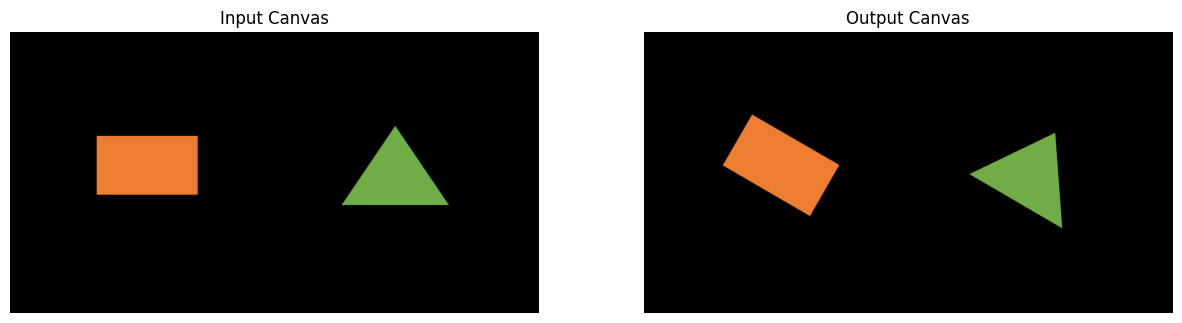

In [7]:
# Read a canvas image and rotate drawings on it.
canvas = cv2.imread('media/canvas1.png')
rotateDrawing(canvas, roi_points=(0,0,canvas.shape[1],canvas.shape[0]), angle=30)

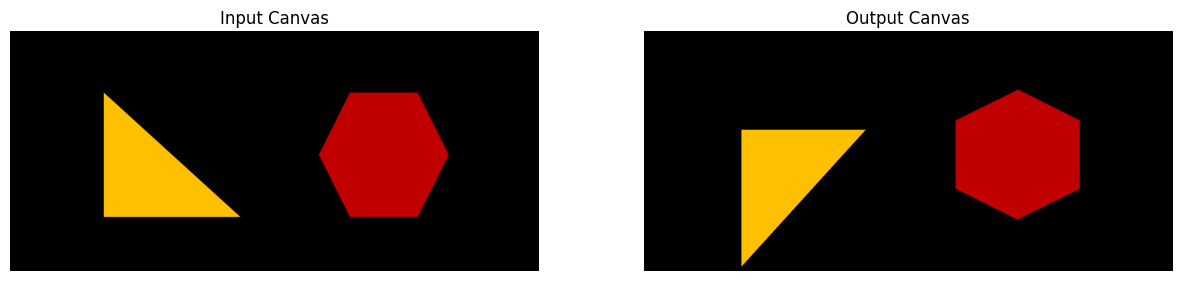

In [8]:
# Read another canvas image and rotate drawings on it.
canvas = cv2.imread('media/canvas2.png')
rotateDrawing(canvas, roi_points=(0,0,canvas.shape[1],canvas.shape[0]), angle=90)

Great! This one too is working smoothly.

## **<font style="color:rgb(134,19,348)">Create a Function to Drag Shapes/Objects</font>**

Now comes the simplest one, we have to drag shapes/objects in the canvas image from one location to the other. We can easily do that by specifying source and destination regions and then creating a function **`dragDrawing()`** that will set the destination region equal to a copy of the source region and then clear out the source region. We will not need any OpenCV function for this operation and will get the required results simply by using [numpy array slicing](https://www.w3schools.com/python/numpy/numpy_array_slicing.asp) technique.


<center><img src='https://drive.google.com/uc?export=download&id=1ppBO85u6z-wALg2SA5inkHRFprtPGaPV'></center>

In [9]:
def dragDrawing(canvas, source_roi, destination_roi, display=True):
    '''
    This function will drag shapes/objects from a source location to the destination location in a canvas image.
    Args:
        canvas:          A black (three channel) image with shapes/objects drawn on in different colors.
        source_roi:      The source region (containing the shapes/objects to drag) of interest coordinates.
        destination_roi: The destination region of interest coordinates.
    Returns:
        output_canvas: A copy of input canvas image with the shapes dragged.
    '''
    
    # Create a copy of the input canvas image.
    output_canvas = canvas.copy()
    
    # Get the source region of interest coordinates.
    source_x1, source_y1, source_x2, source_y2 = source_roi
    
    # Calculate the width and height of the source roi.
    width = source_x2-source_x1
    height = source_y2-source_y1
    
    # Get the destination region of interest coordinates.
    dest_x1, dest_y1, dest_x2, dest_y2 = destination_roi
    
    # Clear the source region of interest.
    output_canvas[source_y1:source_y2, source_x1:source_x2] = 0
    
    # Set the destination region of interest equal to a copy of the source region of interest.
    output_canvas[dest_y1:dest_y1+height, dest_x1:dest_x1+width] = canvas[source_y1:source_y2, source_x1:source_x2].copy()
    
    # Check if the input canvas image and the output canvas image are specified to be displayed.
    if display:
        
        # Display the input canvas image and the output canvas image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(canvas[:,:,::-1]);plt.title("Input Canvas");plt.axis('off');
        plt.subplot(122);plt.imshow(output_canvas[:,:,::-1]);plt.title("Output Canvas");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output canvas image.
        return output_canvas

Now, let's test the dragging operation on a few sample canvas images utilizing the function **`dragDrawing()`** created above.

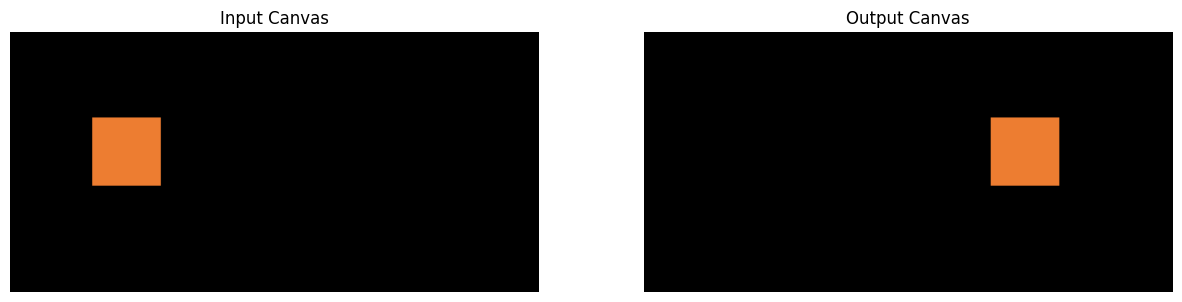

In [10]:
# Read a canvas image and drag drawings on it from first half of the canvas to the second half.
canvas = cv2.imread('media/canvas3.png')
dragDrawing(canvas, source_roi=(0,0,int(canvas.shape[1]/2), canvas.shape[0]),
            destination_roi=(int(canvas.shape[1]/2), 0,canvas.shape[1],canvas.shape[0]))

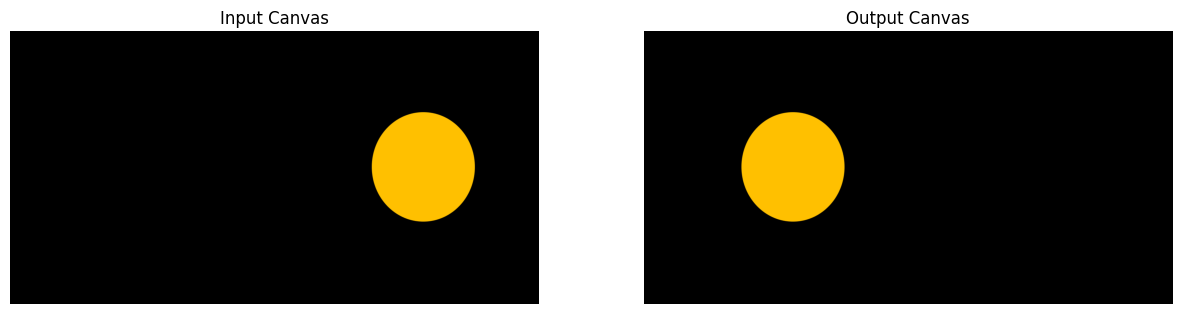

In [11]:
# Read a canvas image and drag drawings on it from second half of the canvas to the first half.
canvas = cv2.imread('media/canvas4.png')
dragDrawing(canvas, source_roi=(int(canvas.shape[1]/2), 0,canvas.shape[1],canvas.shape[0]),
            destination_roi=(0,0,int(canvas.shape[1]/2), canvas.shape[0]))

Perfect! working as expected.

## **<font style="color:rgb(134,19,348)">Manipulate Shapes/Objects in a Real-Time Webcam Feed utilizing Hand Gestures</font>**

We have tested the shapes/objects manipulation on images, now its time to manipulate the shapes/objects in real-time on a webcam feed, for that first we have to create a function **`selectROI()`** that will select the regions (containing the shapes to manipulate) through hand gestures. For resizing, we are specifying the `LOSER` gesture with the right hand, for rotating the user will have to make the `LOSER` gesture with the left hand, and for the dragging, the user will make the `LOSER` gesture with both hands and the region will be selected in real-time as highlighted in the image below. 

<center><img src='https://drive.google.com/uc?export=download&id=1TJQ7Xk0MrMsPmJeE_f-_ArPR94sZEtPP'> </center>

In [12]:
def selectROI(frame, canvas, hands_tips_positions, operation):
    '''
    This function will generate the coordinates of the region selected by the user utilizing hand gestures.
    Args:
        frame:                The current frame/image of a real-time webcam feed.
        canvas:               A black image equal to the webcam feed size, with shapes drawn on.
        hands_tips_positions: A dictionary containing the landmarks of the tips of the fingers of a hand.
        operation:            The manipulation operation like resize, rotate or drag.
    Returns:
        frame:           The frame with the shapes (in the selected region) highlighted.
        roi_coordinates: The selected region (x1, y1, x2, y2) coordinates.
    '''
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Get the x and y coordinates of tip of the index finger of the right hand.
    right_index_x, right_index_y = hands_tips_positions['RIGHT']['INDEX']
    
    # Get the x and y coordinates of tip of the thumb of the right hand.
    right_thumb_x, right_thumb_y = hands_tips_positions['RIGHT']['THUMB']
    
    # Get the x and y coordinates of tip of the index finger of the left hand.
    left_index_x, left_index_y = hands_tips_positions['LEFT']['INDEX']
    
    # Get the x and y coordinates of tip of the thumb of the left hand.
    left_thumb_x, left_thumb_y = hands_tips_positions['LEFT']['THUMB']
        
    # Check if the manipulation operation is 'Resize'.
    # This means that the user is making 'LOSER' hand gesture with right hand.
    if operation == 'Resize':
        
        # Get the selected region (x1, y1, x2, y2) coordinates.
        x1, y1, x2, y2 = 0, right_index_y, right_index_x, right_thumb_y
    
    # Check if the manipulation operation is 'Rotate'.
    # This means that the user is making 'LOSER' hand gesture with left hand.
    elif operation == 'Rotate':
        
        # Get the selected region (x1, y1, x2, y2) coordinates.
        x1, y1, x2, y2 = left_index_x, left_index_y, frame_width, left_thumb_y
    
    # Check if the manipulation operation is 'Drag'.
    # This means that the user is making 'LOSER' hand gesture with both hands.
    elif operation == 'Drag':
        
        # Get the selected region (x1, y1, x2, y2) coordinates.
        x1, y1, x2, y2 = left_index_x, left_index_y, right_index_x, right_thumb_y
    
    # Get the selected region from the frame and canvas image.
    frame_ROI = frame[y1:y2, x1:x2]
    canvas_ROI = canvas[y1:y2, x1:x2]
    
    # Create a binary mask of the selected canvas region, 
    # with values 255 at the objects/shapes regions and 0 at the remaining regions.
    binary_mask = np.zeros(shape=(canvas_ROI.shape[0], canvas_ROI.shape[1]), dtype=np.uint8)
    binary_mask[np.mean(canvas_ROI, axis=2)!=0] = 255
    
    # Perform Contour Detection on the binary mask of the canvas roi.
    contours, _ = cv2.findContours(image=binary_mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    
    # Check if any shapes/objects contours were found in the canvas roi.
    if len(contours)>0:
        
        # Draw the contours to highlight the shapes/objects in the selected region.
        frame_ROI = cv2.drawContours(frame_ROI, contours, contourIdx=-1, color=(255,255,255), thickness=5)
    
    # Initilize a variable to store the selected region (x1, y1, x2, y2) coordinates.
    roi_coordinates = (x1, y1, x2, y2)
    
    # Get the frame and the the selected region coordinates.
    return frame, roi_coordinates

Now the last thing we need is to figure out a way to specify the angle with which we want to rotate the shapes/objects with hand gestures in a webcam feed. There are multiple approaches to accomplish this, what we are doing is specifying two points (landmarks) on a hand and one point on the frame and calculating the angle between these three points (highlighted in the image below) in real-time in the function  **`calculateHandAngle()`**.

<center><img src='https://drive.google.com/uc?export=download&id=15CYjpccdSjGj6ZgLNq3YhNGg0ilTOPEU' width=400> </center>

In [13]:
def calculateHandAngle(frame, results, hand_label, draw=True):
    '''
    This function will calculate the angle of the hand orientation utilizing hand landmarks.
    Args:
        frame:      The image/frame of the hand whose angle is required to be calculated.
        results:    The output of the hands landmarks detection performed on the image.
        hand_label: The label of the hand i.e. left or right, whose angle is required to be calculated.
        draw:       A boolean value that is if set to true the function draws lines between the three
                    points being utilized in calculating angle.
    Returns:
        angle: The calculated angle of the hand utilizing hand landmarks.
    '''
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Initialize a variable to store the hand angle.
    angle = None
    
    # Iterate over the found hands in the frame.
    for hand_index, hand_info in enumerate(results.multi_handedness):
        
        # Check if the hand, we are iterating upon, is the hand of which we want to find the angle.
        if hand_label == hand_info.classification[0].label.upper():
        
            # Retrieve the landmarks of the hand.
            hand_landmarks =  results.multi_hand_landmarks[hand_index]
            
            # Get the wrist landmark of the hand.
            wrist = (int(hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].x*frame_width),
                     int(hand_landmarks.landmark[mp_hands.HandLandmark.WRIST].y*frame_height))
            
            # Get the middle finger mcp landmark of the hand.
            middle_finger_mcp = (int(hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].x*frame_width),
                                 int(hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].y*frame_height))
                        
            
            # Get the three points (x, y) coordinates, we need to calculate the angle.
            x1, y1 = middle_finger_mcp
            x2, y2 = wrist
            x3, y3 = wrist[0], 0

            # Calculate the angle between the three points
            angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))

            # Check if the angle is less than zero.
            if angle < 0:
               
                # Add 360 to the found angle.
                angle += 360

            # Write the calculated hand angle on the frame. 
            cv2.putText(frame, f'Hand Angle: {int(angle)}', (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 2)
            
            # Check if the lines between the three points (we are using to find angle), are specified to be drawn.
            if draw:
                
                # Draw a line from point1 to point 2 and then point2 to point3.
                cv2.line(img=frame, pt1=(x1, y1), pt2=(x2, y2), color=(255, 0, 255), thickness=4)
                cv2.line(img=frame, pt1=(x2, y2), pt2=(x3, y3), color=(255, 0, 255), thickness=4)
            
    # Return the calculated angle.
    return angle

Now finally, it's time to put all the functions we created, together and build a real-time shapes/objects manipulation application. 

In [16]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0, cv2.CAP_DSHOW)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Create Shapes/Objects utilizing Hand Gesture', cv2.WINDOW_NORMAL)

# Initialize a canvas to draw on.
canvas = np.zeros(shape=(int(camera_video.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                         int(camera_video.get(cv2.CAP_PROP_FRAME_WIDTH)), 3),
                  dtype=np.uint8)

# Initialize a variable to store the color value.
paint_color = 0, 255, 0

# Initialize a variable to store the buffer length.
BUFFER_MAX_LENGTH = 2

# Initialize a buffer to store right hand recognized gestures.
right_hand_buffer = deque([], maxlen=BUFFER_MAX_LENGTH)

# Initialize a buffer to store left hand recognized gestures.
left_hand_buffer = deque([], maxlen=BUFFER_MAX_LENGTH)

# Initialize a constant to store the default shape size. 
DEFAULT_SHAPE_SIZE = 100

# Initialize a variable to store the shape size.
shape_size = DEFAULT_SHAPE_SIZE

# Initialize a variable to store the selected shape. 
shape_selected = None

# Initialize a variable to store the rotated shape. 
shapes_rotated = None

# Initialize a list to store the coordinates of the roi selected in the previous frame.
prev_roi = []

# Initialize a list to store the coordinates of the roi selected for rotaion.
rotation_roi = []

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
   
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then 
    # continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)

    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform Hands landmarks detection on the frame.
    frame, results = detectHandsLandmarks(frame, hands, draw=True, display=False)
    
    # Check if the hands landmarks in the frame are detected.
    if results.multi_hand_landmarks:
        
        # Perform right hand gesture recognition.
        right_hand_gesture, hands_tips_positions = recognizeGestures(frame, results, 'RIGHT', draw=False, display=False)
        
        # Check if a known gesture is recognized.
        if right_hand_gesture != 'UNKNOWN':
            
            # Check if all the gestures stored in the buffer are equal to the current gesture.
            if all(right_hand_gesture==gesture for gesture in right_hand_buffer):
                
                # Append the current gesture into the buffer.
                right_hand_buffer.append(right_hand_gesture)
                
            # Otherwise.
            else:
                
                # Clear the buffer.
                right_hand_buffer.clear()
            
        # Perform left hand gesture recognition.
        left_hand_gesture, _ = recognizeGestures(frame, results, 'LEFT', draw=False, display=False)
        
        # Check if a known gesture is recognized.
        if left_hand_gesture != 'UNKNOWN':
            
            # Check if all the gestures stored in the buffer are equal to the current gesture.
            if all(left_hand_gesture==gesture for gesture in left_hand_buffer):
                
                # Append the current gesture into the buffer.
                left_hand_buffer.append(left_hand_gesture)
                
            # Otherwise.
            else:
                
                # Clear the buffer.
                left_hand_buffer.clear()
            
        # Check if the length of the buffer is equal to the maxlength.
        if len(right_hand_buffer) == BUFFER_MAX_LENGTH:

            # Check if the current right hand gesture is 'VICTORY' or ('LOSER' and left hand gesture is not 'LOSER').
            if right_hand_gesture == 'VICTORY' or (right_hand_gesture=='LOSER' and left_hand_gesture!='LOSER'):

                # Calculate the distance between the middle finger tip and thumb tip landmark of the other hand.
                distance = calculateDistance(frame, hands_tips_positions['LEFT']['MIDDLE'],
                                             hands_tips_positions['LEFT']['THUMB'], display=False)

                # Check if the distance is calculated successfully.
                # This will be none in case when the hand is not in the frame.
                if distance:

                    # Get the interpolation function and calculate the new shape size value.
                    shape_size_interp_f = interp1d([30,230], [50, 200])
                    shape_size = int(shape_size_interp_f(distance))

                    # Write the current distance percentage on the frame.
                    cv2.putText(img=frame, text=f'{int((distance-30)/2)}%',org=(frame_width-130, frame_height-430), 
                                fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=paint_color, thickness=3)


                    # Get the interpolation function and calculate the bar value.
                    # This will be used to draw a filled rectangle of height varying with the distance.
                    bar_interp_f = interp1d([30,230],  [frame_height-50, frame_height-400])
                    bar_value = bar_interp_f(distance)  


                    # Draw the filled rectangle with varying height on the frame.
                    cv2.rectangle(frame, (frame_width-80, int(bar_value)), 
                                  (frame_width-50, frame_height-50), (255, 0, 255), -1)

                    # Draw another rectangle around the filled rectangle on the frame.
                    cv2.rectangle(frame, (frame_width-80, frame_height-400),
                                  (frame_width-50, frame_height-50), (0, 255, 0), 6)


            # Draw the selected shape with center at the tip of the middle finger of the hand.
            frame, canvas, shape_selected = drawShapes(frame, canvas, shape_selected, right_hand_gesture,
                                                       hands_tips_positions['RIGHT'], paint_color, 
                                                       shape_size)

            # Check if the current hand gesture is 'VICTORY'.
            if right_hand_gesture == 'VICTORY':

                # Check if a shape is not selected.
                if not shape_selected: 

                    # Select a shape utilizing hand landmarks.
                    shape_selected = selectShape(frame, hands_tips_positions['RIGHT'],
                                                 DEFAULT_SHAPE_SIZE)

            # Check if the current hand gesture is 'LOSER'.
            elif right_hand_gesture == 'LOSER' and left_hand_gesture != 'LOSER':
                
                # Write the current mode enabled on the frame.
                cv2.putText(frame, 'Shape Resize Mode Enabled', (10, frame_height-20),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, paint_color, 2)
                
                # Select a region with shapes you want to resize.
                frame, ROI_points = selectROI(frame, canvas, hands_tips_positions, 'Resize')
                
                # Create a try block to avoid program crash in case of an error during resizing.
                # This is done just to be on a safe side.
                try:
                
                    # Resize the shapes in the selected region.
                    canvas = resizeDrawing(canvas, ROI_points, shape_size, display=False)
                    
                except:
                    pass
                    
            # Check if the length of the buffer is equal to the maxlength.
            if len(left_hand_buffer) == BUFFER_MAX_LENGTH:
                
                # Check if the current left hand gesture is 'LOSER' and right hand gesture is also 'LOSER'.
                if left_hand_gesture == 'LOSER' and right_hand_gesture == 'LOSER':
                    
                    # Write the current mode enabled on the frame.
                    cv2.putText(frame, 'Shape Drag Mode Enabled', (10, frame_height-20),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, paint_color, 2)
                    
                    # Select a region with shapes you want to drag.
                    frame, current_ROI = selectROI(frame, canvas, hands_tips_positions, 'Drag')
                    
                    # Check if a region was selected in the previous frame.
                    if len(prev_roi) > 0:
                        
                        # Create a try block to avoid program crash in case of an error during dragging.
                        # This is done just to be on a safe side.
                        try:
                        
                            # Drag the shapes from the region selected in the previous frame, to the currently selected region. 
                            canvas = dragDrawing(canvas,  source_roi=prev_roi, destination_roi=current_ROI, display=False)
                        
                        except:
                            pass
                    
                    # Update the previous frame selected region coordinates to the currently selected region coordinates. 
                    prev_roi = current_ROI
                
                
                # Otherwise.
                else:
                    
                    # Update the previous frame selected region to an empty list.
                    prev_roi = []
                        
        # Check if the length of the buffer is equal to the maxlength.
        if len(left_hand_buffer) == BUFFER_MAX_LENGTH:
            
            # Check if the current left hand gesture is 'LOSER' and right hand gesture is not 'LOSER'.
            if left_hand_gesture == 'LOSER' and right_hand_gesture != 'LOSER':
                
                # Write the current mode enabled on the frame.
                cv2.putText(frame, 'Shape Rotate Mode Enabled', (10, frame_height-20),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, paint_color, 2)
                
                # Select a region with shapes you want to rotate.
                frame, ROI_points = selectROI(frame, canvas, hands_tips_positions, 'Rotate')
                
                # Calculate the angle with which you want to rotate the shape(s) in the selected region.
                angle = calculateHandAngle(frame, results, hand_label='RIGHT', draw=False)
                
                # Check if a valid angle was found.
                # This will be none in case when the hand is not in the frame.
                if angle:
                    
                    # Create a try block to avoid program crash in case of an error during rotation.
                    # This is done just to be on a safe side.
                    try:
                    
                        # Rotate the shapes in the selected region. 
                        canvas, shapes_rotated, rotation_roi = rotateDrawing(canvas, ROI_points, angle, shapes_rotated, 
                                                                         rotation_roi, display=False)
                    except:
                        pass
                    
            # otherwise.
            else:
                
                # Update the rotated shapes variable to 'None'.
                shapes_rotated = None
                
                # Update the rotation region coordinates to an empty list.
                rotation_roi = []
                                                   
    # Otherwise.
    else:
        
        # Clear the buffers.
        left_hand_buffer.clear()
        right_hand_buffer.clear()
        
        # Update the rotated shapes variable to 'None' and the rotation region coordinates to an empty list.
        shapes_rotated=None
        rotation_roi = []

    # Update the pixel values of the frame with the canvas's values at the indexes where canvas!=0
    # i.e. where canvas is not black and something is drawn there.
    # In short, this will copy the drawings from canvas to the frame.
    frame[np.mean(canvas, axis=2)!=0] = canvas[np.mean(canvas, axis=2)!=0]
    
    # Display the frame.
    cv2.imshow("Create Shapes/Objects utilizing Hand Gesture", frame)
    
   # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if k == 27:
        break
        
# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()



# Additional comments:
#   - I had to lower the buffer size from 20 -> 2
#   - I was having a lot of issues with the gestures
#     when the buffer size is high.
#   - Fortunately, the test went well after lowering it
#   - 

As expected, all the manipulation operations are working fine in real-time as well.

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```